# Todo


* Build PCA from much larger set of sky observations
* work off real spectra (not sky_spectrum)



# Notes
* all experiments are currently in pca_sky1.ipynb and pca_sky3.ipynb 
* this notebook is meant for production

In [1]:
COMMANDLINE = False

In [2]:
if not COMMANDLINE:
    # go wide screen
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))

    # Next two lines force automatic reload of loaded module. Convenient if
    # one is still fiddeling with them.
    %load_ext autoreload
    %autoreload 2

In [3]:
if COMMANDLINE:
    import matplotlib
    matplotlib.use('Agg')

import sys

import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
import os
import glob
from matplotlib import pyplot as plt
if not COMMANDLINE:
    %matplotlib inline

from collections import OrderedDict
import spectrum
from numpy import polyfit,polyval

from xpca import load_skys_for_shotlist
from xpca import save_sky
from xpca import homogenize
from xpca import build_XA
from xpca import build_XB

In [4]:
IFU = "022"; amps=["LL", "LU"]; amps_skysub=["LL"]
IFU = "022"; amps=["LL"]; amps_skysub=["LL"]
#IFU = "022"; amps=["RL", "RU"]; amps_skysub=["RL"]
#IFU = "095"; amps=["LL", "LU"]; amps_skysub=["LL"]
#IFU = "106"; amps=["LL", "LU"]; amps_skysub=["LL"]

fn_shotlist_pca = "/work/04287/mxhf/maverick/hetdex/cubes/shotlist_pca.txt"
fn_shotlist_skyrecon = "/work/04287/mxhf/maverick/hetdex/cubes/shotlist_skyrecon.txt"
kappa = 0.8 # for sky outlier clipping
n_components = 20


fn_shotlist_pca = "/work/04287/mxhf/maverick/hetdex/cubes/shotlist_PCA_COSMOSD.txt"
fn_shotlist_skyrecon = "/work/04287/mxhf/maverick/hetdex/cubes/shotlist_COSMOSD.txt"
#kappa = 1.5 # for sky outlier clipping
n_components = 25
kappa = None # for sky outlier clipping



dir_rebin="/scratch/04287/mxhf/rebin2"
# selct wavelength subrange
wstart = 3495.
wend = 5493.
MEANSHIFT = True

# how many PCA components do we want to maintain?
USEPCA = False

TEST_MOCK_EMISSION = False


In [5]:
if COMMANDLINE:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--ifu', default='022', required=True)
    parser.add_argument('-a', '--Aamps', nargs='+', help='<Required> Source amps.', required=True)
    parser.add_argument('-b', '--Bamp',             help='<Required> Target amp.', required=True)

    parser.add_argument('--shotlist_pca', default="shotlist_pca.txt")
    parser.add_argument('--shotlist_skyrecon', default="shotlist_skyrecon.txt")
    parser.add_argument('--dir_rebin', default="pca_test/rebin")
    parser.add_argument('--sky_kappa', default=0.8, type=float)
    parser.add_argument('--ncomp', default=20, type=int)
    
    args = parser.parse_args()

    n_components = args.ncomp
    kappa = args.sky_kappa # for sky outlier clipping


    IFU=args.ifu
    fn_shotlist_pca = args.shotlist_pca
    fn_shotlist_skyrecon = args.shotlist_skyrecon
    dir_rebin = args.dir_rebin
    amps = args.Aamps
    amps_skysub = [args.Bamp]

In [6]:
# Source shotlist for sky PCA component computation
# all nights of cosmos repeats
with open(fn_shotlist_pca, 'r') as f:
    s = f.read()
shotlist_PCA = s.split()

with open(fn_shotlist_skyrecon, 'r') as f:
    s = f.read()
shotlist_skyrecon = s.split()



# First part: Compute PCA components for A and pseudo-components for B based on a large number of skys

In [7]:
# load rebinned data
wws, skys = load_skys_for_shotlist(dir_rebin, IFU, shotlist_PCA, amps)

_shotids = [k for k in skys[(IFU,amps[0])] ]

# Check that all wavelength arrays and spectra have same dimensions and sampling
ww, start0, stop0, length0, skyx0, skyy0 = homogenize(wws, skys)

# build data matrix A
wwcut, _XAcut = build_XA(IFU, ww, skys, wstart, wend, amps)

No file found like /scratch/04287/mxhf/rebin2/20181210v007/exp01/multi_???_022_???_LL_rebin.pickle. Check rebin dir.
No file found like /scratch/04287/mxhf/rebin2/20181210v007/exp03/multi_???_022_???_LL_rebin.pickle. Check rebin dir.
loading 0 out of 571.


/home1/04287/mxhf/hetdex/xpca/xpca.py:31: RuntimeWarning: divide by zero encountered in true_divide
  skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"]
/home1/04287/mxhf/hetdex/xpca/xpca.py:31: RuntimeWarning: invalid value encountered in true_divide
  skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"]


loading 100 out of 571.
loading 200 out of 571.
loading 300 out of 571.
loading 400 out of 571.
loading 500 out of 571.
start wl =  3494.74 A end wl =  5498.4523582 A len(ww)  1010  shape rb  (112, 1010)
None None None None None
All wavelength arrays have same start wl: True ([3494.74])
All wavelength arrays have same stop wl: True ([5498.4523582])
All wavelength arrays have same length: True ([1010])
All sky arrays have same x size: True ([1010])
All sky arrays have same y size: True ([112])


/home1/04287/mxhf/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 3 results
  r = func(a, **kwargs)
/home1/04287/mxhf/.local/lib/python3.7/site-packages/astropy/stats/biweight.py:117: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)
/home1/04287/mxhf/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)


In [8]:
# Also load B spectra such that we can show them in the histogram
wwsB, skysB = load_skys_for_shotlist(dir_rebin, IFU, shotlist_skyrecon, amps) 

# Check that all wavelength arrays and spectra have same dimensions and sampling
wwB, start0B, stop0B, length0B, skyx0B, skyy0B = homogenize(wwsB, skysB)

# build data matrix A
wwcutB, _XBcut = build_XA(IFU, wwB, skysB, wstart, wend, amps_skysub)

# compute mean signal of B spectra
mmB = biweight_location( _XBcut[:,450:600], axis=1)


loading 0 out of 15.
start wl =  3494.74 A end wl =  5498.4523582 A len(ww)  1010  shape rb  (112, 1010)
None None None None None
All wavelength arrays have same start wl: True ([3494.74])
All wavelength arrays have same stop wl: True ([5498.4523582])
All wavelength arrays have same length: True ([1010])
All sky arrays have same x size: True ([1010])
All sky arrays have same y size: True ([112])


Target spectra fall at -1.06 x sigma and +1.37 x sigma of PCA input spectra.
Setting kappa for PCA input rejection to 1.507.
498 of 571 survive cut.


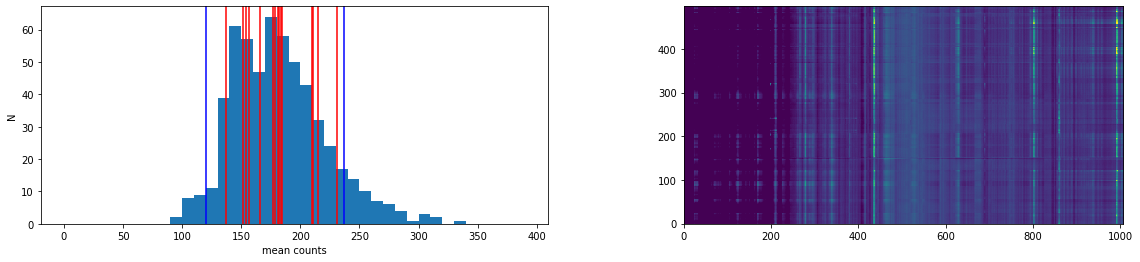

In [9]:
# reject outlier spectra
from astropy.stats import biweight_midvariance, biweight_location

mm = biweight_location( _XAcut[:,450:600], axis=1)
s = np.sqrt( biweight_midvariance(mm) )
m = biweight_location(mm) 

kU = np.abs(mmB.max()-m)/s
kL = np.abs(mmB.min()-m)/s

print("Target spectra fall at -{:.2f} x sigma and +{:.2f} x sigma of PCA input spectra.".format(kL, kU))
if kappa == None:
    kappa = max(kL, kU) * 1.1
    print("Setting kappa for PCA input rejection to {:.3f}.".format(kappa))

start, stop = m-kappa*s, m+kappa*s

#start, stop = 130., 230.

jj = (mm > start) * (mm < stop)
print("{} of {} survive cut.".format(np.sum(jj),len(jj)))

if True:
    
    f = plt.figure(figsize=[20,4])
    ax = plt.subplot(1,2,1)
    plt.hist(mm,bins=np.arange(0,400,10))
    
    for m in mmB:
        plt.axvline(m, c='r')
        

    plt.axvline(start,c='b')
    plt.axvline(stop,c='b')
    plt.xlabel("mean counts")
    plt.ylabel("N")

    ax = plt.subplot(1,2,2)
    plt.imshow((_XAcut.T/mm).T[jj], vmin=.6,vmax=2.4, origin="bottom")
    plt.savefig("{}/histcut_{}_{}.pdf".format(dir_rebin, IFU, "".join(amps)))
    
    
XAcut = _XAcut[jj]
shotids = np.array(_shotids)[jj]


# normilze (usually done by scikit.learn's PCA method also, but useful for plotting etc.)
MA = np.mean(XAcut,axis=0)
if MEANSHIFT:
    XAmean = XAcut - MA
else:
    XAmean = XAcut

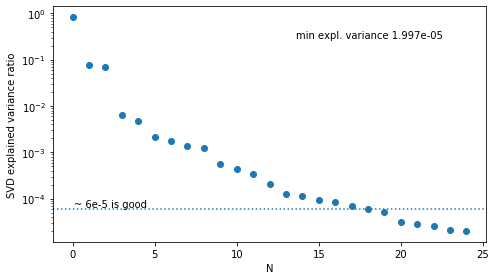

In [10]:
# PCA computation for A

plotfn = "{}/pca_explvarA_{}_{}.pdf".format(dir_rebin, IFU,"".join(amps))

    
PLOT_EXPL_VAR = True
if USEPCA:
    if not MEANSHIFT:
        print("ERROR: PCA must use mean shift") 
    else:
        pcaA = PCA(n_components=n_components)
        pcaA.fit(XAmean)
        if PLOT_EXPL_VAR:
            f = plt.figure(figsize=[7,7])
            ax = plt.subplot(111)
            # explained_variance vs. n components
            plt.plot(pcaA.explained_variance_ratio_, 'o')  
            plt.xlabel("N")
            plt.ylabel("PCA explained variance ratio")
            plt.yscale('log')
            #print(pcaA.singular_values_)
            plt.text(.9,.9,":min expl. variance  {.3e}".formt(pcaA.explained_variance_ratio_[-1]),ha='right', va='top', transform=ax.transAxes)
            f.tight_layout()
            plt.savefig(plotfn)
else:
    # SVD computation for A
    from sklearn.decomposition import TruncatedSVD
    pcaA = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
    pcaA.fit(XAmean)
    
    if PLOT_EXPL_VAR:
        # explained_variance vs. n components
        f = plt.figure(figsize=[7,4])
        ax = plt.subplot(111)
        plt.plot(pcaA.explained_variance_ratio_, 'o')  
        plt.xlabel("N")
        plt.ylabel("SVD explained variance ratio")
        plt.yscale('log')
        #print(pcaA.singular_values_) 
        plt.text(.9,.9,"min expl. variance {:.3e}".format(pcaA.explained_variance_ratio_[-1]),ha='right', va='top', transform=ax.transAxes)
        
        plt.axhline(6e-5, ls=":")
        plt.text( .1, 6e-5, "~ 6e-5 is good", va='bottom', ha='left')
        f.tight_layout()
        plt.savefig(plotfn)

In [11]:
# project pca componets onto
#  mean shifted input spectra
ccA = np.inner(XAmean, pcaA.components_)

# reconstruct pca components through linear combination
rcA = np.matmul( XAmean.T, ccA).T

# they won't be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

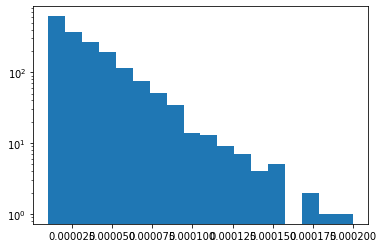

In [12]:
# make sure the result is the same
if not (np.abs( rcA - pcaA.components_) < 1e-6).all():
    print("WARNING: Recontructed PCA components are not (almost) identical to the original ones.")
    dd = np.abs( rcA - pcaA.components_).flatten()

    __ = plt.hist(np.abs( rcA - pcaA.components_).flatten()  , bins=np.linspace( dd.min() ,dd.max() , 20)[1:] )
    plt.yscale("log")

else:
    print("Reconstructed PCAs look good.")

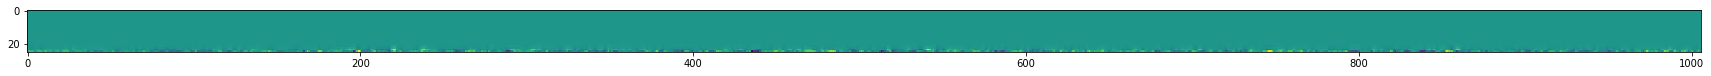

In [13]:
# plot reconstructed - real pca/svd components
if True:
    f=plt.figure(figsize=[30,5])
    plt.imshow( rcA - pcaA.components_ )

/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Max offdiagonal component product is: 2.160e-07 (2.7e-8 is good)


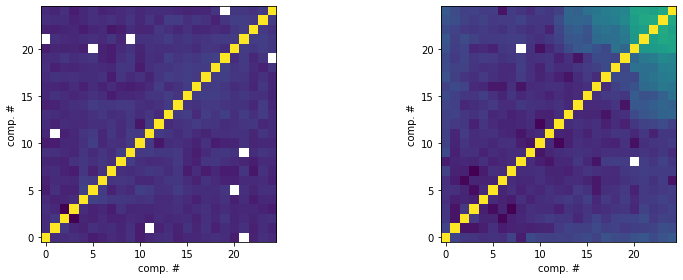

In [14]:
# the othogonality plot
if True:
    plotfn = "{}/pca_orthogA_{}_{}.pdf".format(dir_rebin, IFU,"".join(amps))
    f = plt.figure(figsize=[12,4])
    plt.subplot(121)
    plt.imshow(  np.log( np.abs(np.matmul(pcaA.components_, pcaA.components_.T ))), origin='bottom')
    plt.xlabel("comp. #")
    plt.ylabel("comp. #")
    plt.subplot(122)
    plt.imshow( np.log( np.abs(np.matmul(rcA, rcA.T )) ), origin='bottom')
    plt.xlabel("comp. #")
    plt.ylabel("comp. #")
    f.tight_layout()
    plt.savefig(plotfn)
    
im = np.abs(np.matmul(rcA, rcA.T ))
for i in range(im.shape[0]):
    im[i,i] = 0.
print( "Max offdiagonal component product is: {:.3e} (2.7e-8 is good)".format( im.max() ) )

In [15]:
# save pca components of A
pca_comp_fname = "{}/pca_comp_A_{}_{}.pickle".format(dir_rebin, IFU, "".join(amps))
#pickle.dump(  (MA, pcaA.components_) , open(pca_comp_fname,'wb') , protocol=2   )
pickle.dump(  (MA, rcA) , open(pca_comp_fname,'wb') , protocol=2   )
print("Wrote {}".format(pca_comp_fname))

Wrote /scratch/04287/mxhf/rebin2/pca_comp_A_022_LL.pickle


In [16]:
#generic gaussian
def gauss(mu, sigma, x):
    return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

gg = OrderedDict()

for amp in amps_skysub:
    wwcut, XBcut = build_XB(IFU, amp, ww, skys, wstart, wend)
    # now we subtract the mean of each column!, this is probably unnecassary as
    # the scikit learn PCA already does this, but it helps the plotting and so forth
    MB = np.mean(XBcut[jj],axis=0)
    if MEANSHIFT:
        XBmean = XBcut[jj] - MB
    else:
        XBmean = XBcut[jj]
        
        
    # Add synthetic lines in every B - spectrum
    # random wavelength
    # random sigma (3.5 - 10. A)
    # random amplitude (20 - 100. A)
    if TEST_MOCK_EMISSION:
        #g[ (shot, amp, fiber) ] = []

        for i in range(XBmean.shape[0]):
            for fiber in range(XBmean.shape[1]):
                mu = np.random.uniform()* (wwcut[-1] - wwcut[0]) + wwcut[0]
                sigma = np.random.uniform() * 10. + 3.5
                A = ( np.random.uniform() * 90. + 20.) 

                g = A*gauss(mu, sigma, wwcut)

                print("Adding fake emission line to: ", shotids[i][0], shotids[i][1], amp, fiber)
                XBcut[i,fiber]  = XBcut[i,fiber] + g

                gg[ (shotids[i][0], shotids[i][1], amp, fiber) ] = g
        
    ### reconstruct pca components of all B fibers through linear combination of spectra from B ###
    rcB = OrderedDict() # will hald for all fibers (in the current amp) all the pseudo PCA components
    for fiber in range(XBmean.shape[1]):
        # BUT using projection from A
        rcB[fiber] = np.matmul( XBmean[:,fiber,:].T, ccA).T
        # they wont be normalized yet
        for j,cB in enumerate(rcB[fiber]):
            rcB[fiber][j] = rcB[fiber][j]/np.linalg.norm(rcB[fiber][j])
            
    pca_comp_fname = "{}/pca_comp_B_{}_{}.pickle".format(dir_rebin,IFU,amp)
    pickle.dump(  (MB,rcB) , open(pca_comp_fname,'wb') , protocol=2   )
    print("Wrote {}".format(pca_comp_fname))
    
    if False:
        f = plt.figure()
        plt.imshow( np.arcsinh( np.matmul(rcB[75], rcB[75].T ) ), origin='bottom')

Wrote /scratch/04287/mxhf/rebin2/pca_comp_B_022_LL.pickle


In [17]:
if False:
    # compute projection of input spectra onto PCA basis
    #tA = pcaA.transform(XAmean)
    tA = np.matmul( XAmean, rcA.T)


    # make sure we can reconstuct the spectra from the
    # actual principal components but also from the reconstructed ones
    for i in range(10):
        f = plt.figure(figsize=[15,3])
        plt.subplot(131)
        plt.plot(wwcut, XAmean[i] )
        plt.plot(wwcut,  np.inner(tA, pcaA.components_.T)[i] )
        plt.plot(wwcut,  pcaA.inverse_transform(tA)[i] )


        plt.subplot(132)
        plt.plot(wwcut,  XAmean[i] )
        plt.plot(wwcut,  np.inner(tA, rcA.T)[i] )


        plt.subplot(133)
        plt.plot(wwcut,  np.inner(tA, pcaA.components_.T)[i] )
        plt.plot(wwcut,  np.inner(tA, rcA.T)[i] )


# Now apply this to B

In [18]:
# load pca components of A
pca_comp_fname = "{}/pca_comp_A_{}_{}.pickle".format(dir_rebin, IFU, "".join(amps))

print("Reading {}".format(pca_comp_fname))
MA, rcA = pickle.load( open(pca_comp_fname,'rb'), encoding='iso-8859-1' )

wws, skys = load_skys_for_shotlist(dir_rebin, IFU, shotlist_skyrecon, amps)  

shotids = [k for k in skys[(IFU,amps[0])] ]

# Check that all wavelength arrays and spectra have same dimensions and sampling
# Here we need to pass previous sampling information
# to make sure that array sises are compatible.
ww, __, __, __, __, __ = homogenize(wws, skys, start0, stop0, length0, skyx0, skyy0)
    

# build data matrix A
wwcut, XAcut = build_XA(IFU, ww, skys, wstart, wend, amps)

# normalize 
# but normalize with respect to 
# the mean that we used fot the PCA component calculation
#MA = np.mean(XAcut,axis=0)
if MEANSHIFT:
    XAmean = XAcut - MA
else:
    XAmean = XAcut
# compute projection of input spectra onto PCA basis
ccA2 = np.inner(XAmean, rcA)

Reading /scratch/04287/mxhf/rebin2/pca_comp_A_022_LL.pickle
loading 0 out of 15.
start wl =  3494.74 A end wl =  5498.4523582 A len(ww)  1010  shape rb  (112, 1010)
3494.74 5498.4523582 1010 1010 112
All wavelength arrays have same start wl: True ([3494.74])
All wavelength arrays have same stop wl: True ([5498.4523582])

/home1/04287/mxhf/hetdex/xpca/xpca.py:31: RuntimeWarning: divide by zero encountered in true_divide
  skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"]
/home1/04287/mxhf/hetdex/xpca/xpca.py:31: RuntimeWarning: invalid value encountered in true_divide
  skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"]
/home1/04287/mxhf/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 3 results
  r = func(a, **kwargs)
/home1/04287/mxhf/.local/lib/python3.7/site-packages/astropy/stats/biweight.py:117: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)



All wavelength arrays have same length: True ([1010])
All sky arrays have same x size: True ([1010])
All sky arrays have same y size: True ([112])


In [19]:
# Now reconstruct sky

from matplotlib.backends.backend_pdf import PdfPages

for amp in amps_skysub:
    B = (IFU, amp) 

    # load pca components of B
    pca_comp_fname = "{}/pca_comp_B_{}_{}.pickle".format(dir_rebin, IFU,amp)
    MB, rcB = pickle.load( open(pca_comp_fname,'rb'), encoding='iso-8859-1' )


    wwcut, XBcut = build_XB(IFU, amp, ww, skys, wstart, wend)

    if TEST_MOCK_EMISSION:
        for i in range(XBmean.shape[0]):
            for fiber in range(XBmean.shape[1]):
                try:
                    XBcut[i,fiber]  = XBcut[i,fiber] + gg[ (shotids[i][0], shotids[i][1], amp, fiber) ]
                except:
                    #print("1 No info for ", (shotids[i][0], shotids[i][1], amp, fiber) )
                    pass


    # now we subtract the mean of each column!, this is probably unnecassary as
    # the scikit learn PCA already does this, but it helps the plotting and so forth
    #MB = np.mean(XBcut,axis=0)
    if MEANSHIFT:
        XBmean = XBcut - MB
    else:
        XBmean = XBcut

    ### reconstruct pca components of all B fibers through linear combination of spectra from B ###
    #rcB = OrderedDict() # will hald for all fibers (in the current amp) all the pseudo PCA components
    #for fiber in range(XBmean.shape[1]):
    #    # BUT using projection from A
    #    rcB[fiber] = np.matmul( XBmean[:,fiber,:].T, ccA2).T
    #    # they wont be normalized yet
    #    for j,cB in enumerate(rcB[fiber]):
    #        rcB[fiber][j] = rcB[fiber][j]/np.linalg.norm(rcB[fiber][j])

    # Now reconstruct sky for all exposures and fibers
    B_recon_sky = np.zeros_like(XBmean)
    for i in range(XBmean.shape[0]): # loop over exposures
        for fiber in range(XBmean.shape[1]):  # loop over fibers
            # now compute sky from pseudo PCA components of B
            # according to weights of A
            B_recon_sky[i,fiber,:] = np.inner(ccA2, rcB[fiber].T)[i] + MB[fiber,:]


            y  = XBmean[i,fiber,:] + MB[fiber,:] # original sky in B
            ry = B_recon_sky[i,fiber,:]          # reconstructed sky in B
            res = ry-y

            p = polyfit(wwcut, res, deg=5)
            B_recon_sky[i,fiber,:] -= polyval(p, wwcut)

   

In [ ]:
from IPython.display import display

qa_pdf = "{}/pca_comp_B_{}.pdf".format(dir_rebin, IFU)

with PdfPages(qa_pdf) as pdf:
    for amp in amps_skysub:
        B = (IFU, amp)

        # Quality control
        # plot for 10 randomly picked exposures
        # reconstrcuted sky and residuals of one (or a few) fiber(s)
        
        np.random.seed(42)
        qa_exposures = np.array( np.random.uniform(size=10) * XBmean.shape[0], dtype=int)
        qa_fibers = [75]

 
        for i in qa_exposures: # loop over exposures
            for fiber in qa_fibers:  # loop over fibers
                f = plt.figure(figsize=[15,3])
                ax = plt.subplot(121)

                y  = XAmean[i] + MA
                ry = np.inner(ccA2, rcA.T)[i] + MA
                res = ry-y
                plt.plot(wwcut,  y )
                plt.plot(wwcut,   ry )
                plt.twinx()
                plt.plot(wwcut,   res/y, 'g.'  )
                plt.ylim([-.02,.08])
                plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
                plt.text(0.05,0.95,"A\n{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  fiber ), transform = ax.transAxes, ha='left',va='top')

                ax = plt.subplot(122, sharex=ax)
                y  = XBmean[i,fiber,:] + MB[fiber,:] # original sky in B
                ry = B_recon_sky[i,fiber,:]          # reconstructed sky in B
                res = y-ry

                plt.plot(wwcut,   y )
                plt.plot(wwcut,   ry )
                plt.twinx()

                plt.plot(wwcut,   res/y, 'g.' )
                plt.ylim([-.02,.08])
                plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
                plt.text(0.05,0.95,"B\n{}\n{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  B[1], fiber ), transform = ax.transAxes, ha='left',va='top')

                if TEST_MOCK_EMISSION:
                    try:
                        plt.plot(wwcut,   gg[ (shotids[i][0], shotids[i][1], amp, fiber) ], 'r-' , drawstyle='steps-mid', alpha=.5)
                    except:
                        print("No info for ", (shotids[i][0], shotids[i][1], amp, fiber) )
                        pass


                display(f)
                pdf.savefig()  # saves the current figure into a pdf page

                plt.close()


        for i,k in enumerate(shotids):

            save_sky(IFU, amp , k, wwcut, B_recon_sky[i], dir_rebin)

In [90]:
if TEST_MOCK_EMISSION:
    # Finally, check how well we are doing NOT subtracting off (fake) emission lines.
    # Make sure we can reconstuct the spectra from the
    # actual principal components for A but also from the reconstructed ones for B
    fiber  = 75
    
    NMAX = 20
    N =  min(XBmean.shape[0],NMAX)
    ncol_nrow = np.abs( np.ceil( np.sqrt(N) ) )
    
    
    f = plt.figure(figsize=[15,15])
        
    for i in range(N):
            ax = plt.subplot(ncol_nrow,ncol_nrow,i+1)
            y  = XBmean[i,fiber,:] + MB[fiber,:] # original sky in B

            ry = np.inner(ccA2, rcB[fiber].T)[i] + MB[fiber,:]

            res = y-ry

            wc = wwcut[np.argmax( gg[ (shotids[i][0], shotids[i][1], amp, fiber) ])]
            ii = (wwcut > (wc-100.)) * (wwcut < (wc+100.))

            plt.plot(wwcut[ii],   res[ii], 'g-' , drawstyle='steps-mid')
            plt.ylim([-2,10.])
            plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')

            plt.plot(wwcut[ii],   gg[ (shotids[i][0], shotids[i][1], amp, fiber) ][ii], 'r-' , drawstyle='steps-mid', alpha=.5)

            plt.xlabel("wavelength [A]")


20181215v031 exp01 022 LL : ['/scratch/04287/mxhf/rebin2/20181215v031/exp01/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20181215v031 exp02 022 LL : ['/scratch/04287/mxhf/rebin2/20181215v031/exp02/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20181215v031 exp03 022 LL : ['/scratch/04287/mxhf/rebin2/20181215v031/exp03/pca_multi_xxx_022_xxx_LL_rebin.pickle']


/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


20190104v018 exp01 022 LL : ['/scratch/04287/mxhf/rebin2/20190104v018/exp01/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190104v018 exp02 022 LL : ['/scratch/04287/mxhf/rebin2/20190104v018/exp02/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190104v018 exp03 022 LL : ['/scratch/04287/mxhf/rebin2/20190104v018/exp03/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190105v022 exp01 022 LL : ['/scratch/04287/mxhf/rebin2/20190105v022/exp01/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190105v022 exp02 022 LL : ['/scratch/04287/mxhf/rebin2/20190105v022/exp02/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190105v022 exp03 022 LL : ['/scratch/04287/mxhf/rebin2/20190105v022/exp03/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190108v013 exp01 022 LL : ['/scratch/04287/mxhf/rebin2/20190108v013/exp01/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190108v013 exp02 022 LL : ['/scratch/04287/mxhf/rebin2/20190108v013/exp02/pca_multi_xxx_022_xxx_LL_rebin.pickle']
20190108v013 exp03 022 LL : ['/scratch/04287/mxhf/rebin2/20190108v013/ex

/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in subtract


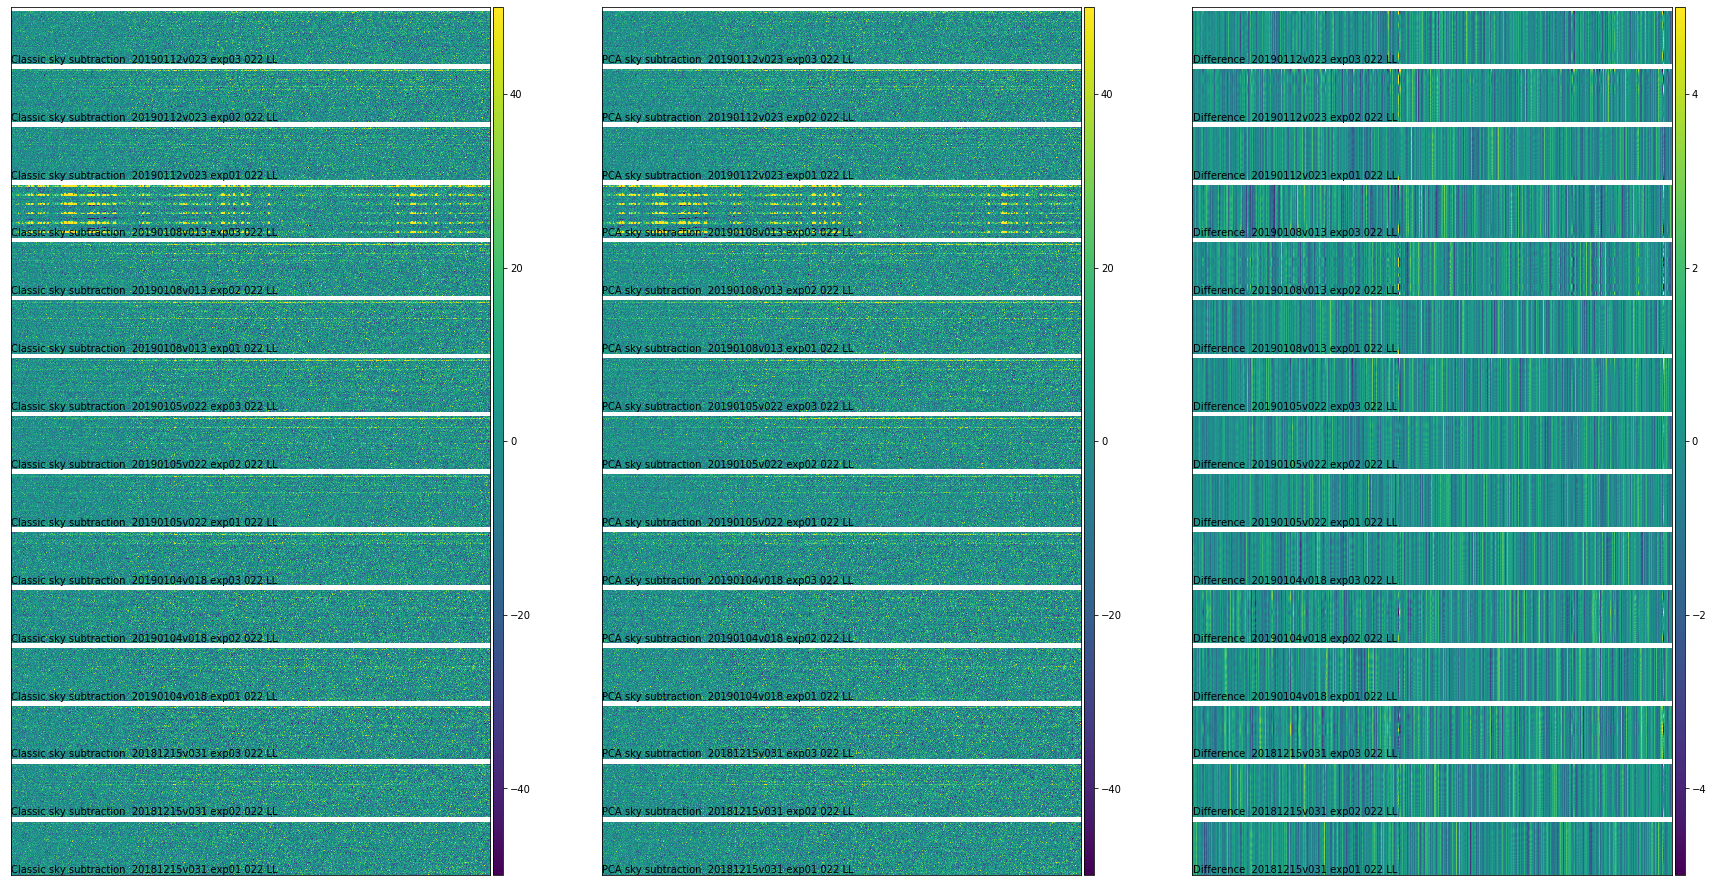

In [103]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sky_subtracted = []
pca_sky_subtracted = []
res_stds = []

yy = []
labels = []
ypos = 0
for shot,exp in shotids[:]:
    for amp in amps_skysub:
        ff = glob.glob("{}/{}/{}/pca_multi_???_{}_???_{}_rebin.pickle".format(dir_rebin, shot,exp,IFU,amp))
        print(shot,exp,IFU,amp,":", ff)
        ww,dd = pickle.load( open(ff[0],'rb'), encoding='iso-8859-1' )
        sky_subtracted.append(dd["sky_subtracted"])
        sky_subtracted.append(1./np.zeros([10,dd["sky_subtracted"].shape[1]]))
        pca_sky_subtracted.append(dd["pca_sky_subtracted"])
        pca_sky_subtracted.append(1./np.zeros([10,dd["pca_sky_subtracted"].shape[1]]))
        
        r = (dd["sky_subtracted"] - dd["pca_sky_subtracted"])/dd["sky_spectrum"]
        res_stds.append(np.nanstd(r, axis=1 ))
        
        yy.append(ypos)
        ypos += 122
        labels.append( "{} {} {} {}".format(shot,exp,IFU,amp) )
        
        
sky_subtracted = np.vstack(sky_subtracted)
pca_sky_subtracted = np.vstack(pca_sky_subtracted)
res_stds = np.hstack(res_stds)


qa_pdf = "{}/pca_vs_normal_B_{}.pdf".format(dir_rebin, IFU)

with PdfPages(qa_pdf) as pdf:

    sky_subtracted = np.vstack(sky_subtracted)
    pca_sky_subtracted = np.vstack(pca_sky_subtracted)
    res_stds = np.hstack(res_stds)


    vmin = -50.
    vmax =  50.

    f = plt.figure(figsize=[30,30])

    ax1 = plt.subplot(131)
    im1 = plt.imshow( sky_subtracted, vmin=vmin, vmax=vmax, origin='bottom', interpolation='none')
    for y,l in zip(yy,labels):
        plt.text(0.,y, "Classic sky subtraction  " + l, va='bottom', ha='left')
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im1, cax=cax, orientation='vertical')


    ax2 = plt.subplot(132)
    im2 = plt.imshow( pca_sky_subtracted, vmin=vmin, vmax=vmax, origin='bottom', interpolation='none')
    for y,l in zip(yy,labels):
        plt.text(0.,y, "PCA sky subtraction  " + l, va='bottom', ha='left')
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im2, cax=cax, orientation='vertical')

    ax3 = plt.subplot(133)

    im3 = plt.imshow( sky_subtracted-pca_sky_subtracted, vmin=vmin/10., vmax=vmax/10., origin='bottom', interpolation='none')
    for y,l in zip(yy,labels):
        plt.text(0.,y, "Difference  " + l, va='bottom', ha='left')   
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im3, cax=cax, orientation='vertical')

    qa_pdf = "{}/pca_vs_normal_B_{}.pdf".format(dir_rebin, IFU)
    f.savefig(qa_pdf)

In [104]:
sys.exit(0)

SystemExit: 0

/home1/04287/mxhf/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# old plotting routines

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

qa_pdf = "{}/pca_vs_normal_B_{}.pdf".format(dir_rebin, IFU)
            
f = plt.figure(figsize=[20,40])
    
#with PdfPages(qa_pdf) as pdf:
count = 0
N = len(shotids) * len(amps_skysub)
for shot,exp in shotids[:]:
    for amp in amps_skysub:
        ff = glob.glob("{}/{}/{}/pca_multi_???_{}_???_{}_rebin.pickle".format(dir_rebin, shot,exp,IFU,amp))
        #print(shot,exp,IFU,amp,":", ff)
        ww,dd = pickle.load( open(ff[0],'rb'), encoding='iso-8859-1' )

        vmin = -50.
        vmax =  50.

        #vmin = None
        #vmax = None

        ax1 = plt.subplot(N,3,1 + count)
        im1 = plt.imshow( dd["sky_subtracted"], vmin=vmin, vmax=vmax)
        plt.text(.1,1., "Classic sky subtraction    {} {} {} {}".format(shot,exp,IFU,amp), va='bottom', ha='left')

        ax2 = plt.subplot(N,3,2 + count)
        im2 = plt.imshow( dd["pca_sky_subtracted"], vmin=vmin, vmax=vmax)
        plt.text(.1,1., "PCA sky subtraction", va='bottom', ha='left')

        ax3 = plt.subplot(N,3,3 + count)
        im3 = plt.imshow( dd["sky_subtracted"]-(dd["pca_sky_subtracted"]), vmin=vmin/10., vmax=vmax/10.)
        plt.text(.1,1., "Difference", va='bottom', ha='left')

        for (ax,im) in [(ax1,im1), (ax2,im2), (ax3,im3)]:
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='2%', pad=0.05)
            f.colorbar(im, cax=cax, orientation='vertical')
            #plt.show()
        #display(f)
        #pdf.savefig()  # saves the current figure into a pdf page

        #plt.close()

        count += 3

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

qa_pdf = "{}/pca_vs_normal_sky_B_{}.pdf".format(dir_rebin, IFU)

with PdfPages(qa_pdf) as pdf:

    for shot,exp in shotids[:]:
        for amp in amps_skysub:
            ff = glob.glob("{}/{}/{}/pca_multi_???_{}_???_{}_rebin.pickle".format(dir_rebin, shot,exp,IFU,amp))
            print(shot,exp,IFU,amp,":", ff)
            ww,dd = pickle.load( open(ff[0],'rb'), encoding='iso-8859-1' )

            vmin =  0.
            vmax =  400.

            #vmin = None
            #vmax = None
            f = plt.figure(figsize=[40,7])
            ax1 = plt.subplot(131)
            im1 = plt.imshow( dd["sky_spectrum"], vmin=vmin, vmax=vmax)
            plt.text(.1,1., "Classic sky spectrum    {} {} {} {}".format(shot,exp,IFU,amp), va='bottom', ha='left')
            
            ax2 = plt.subplot(132)
            im2 = plt.imshow( dd["pca_sky_spectrum"]+dd['sky_spectrum']-dd['pca_sky_spectrum'], vmin=vmin, vmax=vmax)
            plt.text(.1,1., "PCA sky spectrum", va='bottom', ha='left')

            ax3 = plt.subplot(133)
            im3 = plt.imshow( dd["sky_spectrum"]-dd["pca_sky_spectrum"], vmin=-10., vmax=10.)
            plt.text(.1,1., "Difference", va='bottom', ha='left')

            for (ax,im) in [(ax1,im1), (ax2,im2), (ax3,im3)]:
                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)
        
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='2%', pad=0.05)
                f.colorbar(im, cax=cax, orientation='vertical')
                #plt.show()
            display(f)
            pdf.savefig()  # saves the current figure into a pdf page

            plt.close()